In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#inputs = inputs.to(device)
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [2]:
import os
import json
# 其中的部分数据
filename = 'need_to_use.json'
data = open(filename, encoding='utf-8')
strJson1 = json.load(data)

In [3]:
list_all = []
for i in strJson1:
    list_all.append(i)
    for m in strJson1[i]['fans']:
        list_all.append(str(m['id']))
    for m in strJson1[i]['followers']:
        list_all.append(str(m['id']))
set_actualall = set(list_all)
list_actualall = list(set_actualall)
len(list_actualall)

21141

In [4]:
list_links = []
for i in strJson1:
    for m in strJson1[i]['fans']:
        link = (i,str(m['id']))
        list_links.append(link)
    for m in strJson1[i]['followers']:
        link = (str(m['id']),i)
        list_links.append(link)
set_actuallink = set(list_links)
list_actuallinks = list(set_actuallink)
len(set_actuallink)

29326

In [5]:
adj_matrix_data = []
for i in range(len(set_actuallink)):
    adj_matrix_data.append(1)
len(adj_matrix_data)

29326

In [6]:
list_actuallinks[2:5]

[('1751362214', '7471747141'),
 ('5984715712', '6808152838'),
 ('5792240237', '3211818542')]

In [7]:
def get_index(id):
    p = list_actualall.index(id)
    return p

In [8]:
import pandas as pd
data = pd.read_csv('graph2.csv',encoding = 'utf-8')
import numpy as np
# 构建一个全为0的矩阵
A = np.zeros((len(list_actualall),len(list_actualall)))
for i in strJson1:
    index_i = get_index(i)
    for m in strJson1[i]['fans']:
        index_m = get_index(str(m['id']))
        A[index_i][index_m] = 1
    for m in strJson1[i]['followers']:
        index_m = get_index(str(m['id']))
        A[index_m][index_i] = 1

In [9]:
len(list_actualall)

21141

In [10]:
X = A.nonzero()
X

(array([    1,     3,     9, ..., 21137, 21138, 21138]),
 array([19023, 19246, 10346, ..., 18022, 11603, 15713]))

In [11]:
len(adj_matrix_data)
for i in X:
    print(max(i))

21138
21140


In [12]:
X = A.nonzero()
X
from scipy.sparse import *

A = csr_matrix((adj_matrix_data,X),shape=(len(list_actualall),len(list_actualall)))

In [13]:
print(A)

  (1, 19023)	1
  (3, 19246)	1
  (9, 10346)	1
  (11, 13258)	1
  (12, 15385)	1
  (12, 17767)	1
  (13, 7661)	1
  (14, 2918)	1
  (15, 11053)	1
  (17, 8069)	1
  (17, 14348)	1
  (23, 5418)	1
  (24, 800)	1
  (24, 10028)	1
  (26, 19884)	1
  (29, 19319)	1
  (33, 7521)	1
  (34, 7360)	1
  (36, 18272)	1
  (37, 1397)	1
  (38, 8127)	1
  (39, 8069)	1
  (40, 8069)	1
  (41, 1073)	1
  (42, 18022)	1
  :	:
  (21110, 19023)	1
  (21113, 10325)	1
  (21114, 8069)	1
  (21115, 9432)	1
  (21116, 7980)	1
  (21117, 11053)	1
  (21122, 7974)	1
  (21122, 16746)	1
  (21122, 17271)	1
  (21125, 5105)	1
  (21125, 10346)	1
  (21127, 19015)	1
  (21128, 7961)	1
  (21128, 19023)	1
  (21129, 10245)	1
  (21130, 17423)	1
  (21131, 8133)	1
  (21133, 18373)	1
  (21134, 5105)	1
  (21134, 20032)	1
  (21136, 7961)	1
  (21136, 15385)	1
  (21137, 18022)	1
  (21138, 11603)	1
  (21138, 15713)	1


# Defining and training the model

Load the dataset
 - `A` (adjacency matrix) is a `scipy.sparse.csr_matrix` of size `[N, N]`
 - `X` (attribute matrix) is a `scipy.sparse.csr_matrix` of size `[N, D]`
 - `Z_gt` (binary community affiliation matrix) is a `np.ndarray` of size `[N, K]`

In [14]:
K = 20

Define the hyperparameters

In [15]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 1200        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = False     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

Select & normalize the feature matrix

For some datasets where the features are very informative / correlated with the community structure it's better to use `X` as input (e.g. co-authorship networks w/ keywords as node features). Otherwise, you should try using `A` or `[A, X]` as input.

In [16]:
from typing import Union
def to_sparse_tensor(matrix: Union[sp.spmatrix, torch.Tensor]
                     ) -> torch.sparse.FloatTensor:
    """Convert a scipy sparse matrix to a torch sparse tensor.

    Args:
        matrix: Sparse matrix to convert.
        cuda: Whether to move the resulting tensor to GPU.

    Returns:
        sparse_tensor: Resulting sparse tensor (on CPU or on GPU).

    """
    if sp.issparse(matrix):
        coo = matrix.tocoo()
        indices = torch.LongTensor(np.vstack([coo.row, coo.col]))
        values = torch.FloatTensor(coo.data)
        shape = torch.Size(coo.shape)
        sparse_tensor = torch.sparse.FloatTensor(indices, values, shape)
    elif torch.is_tensor(matrix):
        row, col = matrix.nonzero().t()
        indices = torch.stack([row, col])
        values = matrix[row, col]
        shape = torch.Size(matrix.shape)
        sparse_tensor = torch.sparse.FloatTensor(indices, values, shape)
#     else:
#         raise ValueError(f"matrix must be scipy.sparse or torch.Tensor (got {type(matrix)} instead).")
#     if cuda:
#         sparse_tensor = sparse_tensor.cuda()
    return sparse_tensor.coalesce()

In [17]:
from sklearn.preprocessing import normalize
# 做正则化
x_norm = normalize(A)  # node features
x_norm
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = to_sparse_tensor(x_norm).to(device)

In [18]:
x_norm.shape

torch.Size([21141, 21141])

Define the GNN model

In [19]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 1000        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

In [20]:
def sparse_or_dense_dropout(x, p=0.5, training=True):
    if isinstance(x, torch.sparse.FloatTensor):
        new_values = F.dropout(x.values(), p=p, training=training)
        return torch.sparse.FloatTensor(x.indices(), new_values, x.size())
    else:
        return F.dropout(x, p=p, training=training)


class GraphConvolution(nn.Module):
    """Graph convolution layer.

    Args:
        in_features: Size of each input sample.
        out_features: Size of each output sample.

    """
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(in_features, out_features))
        self.bias = nn.Parameter(torch.empty(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        return adj @ (x @ self.weight) + self.bias


class GCN(nn.Module):
    """Graph convolution network.

    References:
        "Semi-superivsed learning with graph convolutional networks",
        Kipf and Welling, ICLR 2017
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.5, batch_norm=False):
        super().__init__()
        self.dropout = dropout
        layer_dims = np.concatenate([hidden_dims, [output_dim]]).astype(np.int32)
        self.layers = nn.ModuleList([GraphConvolution(input_dim, layer_dims[0])])
        for idx in range(len(layer_dims) - 1):
            self.layers.append(GraphConvolution(layer_dims[idx], layer_dims[idx + 1]))
        if batch_norm:
            self.batch_norm = [
                nn.BatchNorm1d(dim, affine=False, track_running_stats=False) for dim in hidden_dims
            ]
        else:
            self.batch_norm = None

    @staticmethod
    def normalize_adj(adj : sp.csr_matrix):
        """Normalize adjacency matrix and convert it to a sparse tensor."""
        if sp.isspmatrix(adj):
            adj = adj.tolil()
            adj.setdiag(1)
            adj = adj.tocsr()
            deg = np.ravel(adj.sum(1))
            deg_sqrt_inv = 1 / np.sqrt(deg)
            adj_norm = adj.multiply(deg_sqrt_inv[:, None]).multiply(deg_sqrt_inv[None, :])
        elif torch.is_tensor(adj):
            deg = adj.sum(1)
            deg_sqrt_inv = 1 / torch.sqrt(deg)
            adj_norm = adj * deg_sqrt_inv[:, None] * deg_sqrt_inv[None, :]
        return to_sparse_tensor(adj_norm)

    def forward(self, x, adj):
        for idx, gcn in enumerate(self.layers):
            if self.dropout != 0:
                x = sparse_or_dense_dropout(x, p=self.dropout, training=self.training)
            x = gcn(x, adj)
            if idx != len(self.layers) - 1:
                x = F.relu(x)
                if self.batch_norm is not None:
                    x = self.batch_norm[idx](x)
        return x

    def get_weights(self):
        """Return the weight matrices of the model."""
        return [w for n, w in self.named_parameters() if 'bias' not in n]

    def get_biases(self):
        """Return the bias vectors of the model."""
        return [w for n, w in self.named_parameters() if 'bias' in n]



In [21]:
N = 21141

In [22]:
K = 20

In [23]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).to(device)
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

/Users/daigaku/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(x_norm, adj_norm))
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

In [25]:
def clustering_coef(Z_pred, adj):
    """Compute weighted average of clustering coefficients of communities."""
    def clustering_coef_community(ind, adj):
        """Compute clustering coefficient of a single community."""
        adj_com = adj[ind][:, ind]
        n = ind.sum()
        if n < 3:
            return 0
        # Number of possible triangles
        possible = (n - 2) * (n - 1) * n / 6
        # Number of existing triangles
        existing = (adj_com @ adj_com @ adj_com).diagonal().sum() / 6
        return existing / possible

    Z_pred = Z_pred.astype(bool)
    com_sizes = Z_pred.sum(0)
    clust_coefs = np.array([clustering_coef_community(Z_pred[:, c], adj) for c in range(Z_pred.shape[1])])
    return clust_coefs @ com_sizes / com_sizes.sum()

In [26]:
x_norm.shape

torch.Size([21141, 21141])

In [27]:
def loss_full( emb, adj):
        """Compute BerPo loss for all edges & non-edges in a graph."""
        e1, e2 = adj.nonzero()
        edge_dots = torch.sum(emb[e1] * emb[e2], dim=1)
        loss_edges = -torch.sum(torch.log(-torch.expm1(-self.eps - edge_dots)))

        # Correct for overcounting F_u * F_v for edges and nodes with themselves
        self_dots_sum = torch.sum(emb * emb)
        correction = self_dots_sum + torch.sum(edge_dots)
        sum_emb = torch.sum(emb, dim=0, keepdim=True).t()
        loss_nonedges = torch.sum(emb @ sum_emb) - correction

        if self.balance_loss:
            neg_scale = 1.0
        else:
            neg_scale = self.num_nonedges / self.num_edges
        return (loss_edges / self.num_edges + neg_scale * loss_nonedges / self.num_nonedges) / (1 + neg_scale)



In [28]:
A.nonzero()

(array([    1,     3,     9, ..., 21137, 21138, 21138], dtype=int32),
 array([19023, 19246, 10346, ..., 18022, 11603, 15713], dtype=int32))

Training loop

In [29]:
import matplotlib.pyplot as plt


/Users/daigaku/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch    0, loss.full = 0.5964
Epoch   25, loss.full = 0.1684
Epoch   50, loss.full = 0.1484
Epoch   75, loss.full = 0.1290
Epoch  100, loss.full = 0.1195
Epoch  125, loss.full = 0.1114
Epoch  150, loss.full = 0.1044
Epoch  175, loss.full = 0.1012
Epoch  200, loss.full = 0.1073
Epoch  225, loss.full = 0.0899
Epoch  250, loss.full = 0.0868
Epoch  275, loss.full = 0.0871
Epoch  300, loss.full = 0.0851
Epoch  325, loss.full = 0.0864
Epoch  350, loss.full = 0.0824
Epoch  375, loss.full = 0.0794
Epoch  400, loss.full = 0.0781
Epoch  425, loss.full = 0.0779
Epoch  450, loss.full = 0.0789
Epoch  475, loss.full = 0.0751
Epoch  500, loss.full = 0.0752
Epoch  525, loss.full = 0.0744
Epoch  550, loss.full = 0.0776
Epoch  575, loss.full = 0.0783
Epoch  600, loss.full = 0.0743
Epoch  625, loss.full = 0.0784
Epoch  650, loss.full = 0.0727
Epoch  675, loss.full = 0.0744
Epoch  700, loss.full = 0.0766
Epoch  725, loss.full = 0.0755
Epoch  750, loss.full = 0.0752
Epoch  775, loss.full = 0.0710
Epoch  8

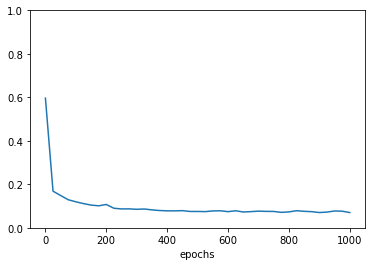

In [30]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)
train_loss = []
for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}')
            train_loss.append(val_loss)
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
                
    #train_loss.append(val_loss)
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    #train_loss.append(loss)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()
    
x = []
for i in range(len(train_loss)):
    x.append(i*25)
plt.plot(x,train_loss)

plt.xlabel('epochs')
plt.ylim(0,1.0)
plt.show()

Depending on whether you use balanced loss or not, you should (probably) use different threshold values. From my experience, following are reasonable defaults:
 - for `balance_loss = True`: `thresh = 0.5`
 - for `balance_loss = False`: `thresh = 0.01`
 
You can look at the distribution of the non-zero entries of `Z` to decide on a good value for the threshold. 
I guess it makes sense to select a value that lies in the leftmost "valley" of histogram below. 
You can also look at the unsupervised metrics in the next section of this notebook to make an informed choice.

Note that all of these are just speculations based on the behavior that I observed for a handful of datasets, YMMV.

In [31]:
thresh = 0.5

Z = F.relu(gnn(x_norm, adj_norm))
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
#print(f'Final nmi = {get_nmi(thresh):.3f}')

# Analyzing the results

### Visualize the adjacency matrix sorted by the communities

In [32]:
for i in range(20):
    print(Z_pred[i].nonzero())

(array([], dtype=int64),)
(array([8]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([13]),)
(array([], dtype=int64),)
(array([3]),)
(array([], dtype=int64),)
(array([10]),)
(array([], dtype=int64),)
(array([9]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [33]:
Z_pred

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [34]:
print(np.argwhere(Z_pred==True))

[[    1     8]
 [    9    13]
 [   11     3]
 ...
 [21134     3]
 [21136     1]
 [21137    19]]


In [35]:
list_True = np.argwhere(Z_pred == True)

In [36]:
# Sizes of detected communities
print(len(Z_pred.sum(0)))

20


In [37]:
len(list_True)

10063

In [38]:
#dict_commu = {}
id_list = []
for i in list_True:
    id_no = str(list_actualall[i[0]])
    id_list.append(id_no)
    #print(id_no)
#id_list.to_csv('id_text.csv',encoding = 'utf-8')

In [39]:
list_all_commu = []
for i in list_True:
    dict_id = {}
    comm_no = str(i[1])
    dict_id[comm_no] = str(list_actualall[i[0]])
    list_all_commu.append(dict_id)
        

In [40]:
list_all_commu

[{'8': '6408851363'},
 {'13': '1891453505'},
 {'3': '6061180654'},
 {'10': '1779963950'},
 {'9': '2625933257'},
 {'2': '1790597487'},
 {'11': '1790597487'},
 {'1': '6739152721'},
 {'3': '6739152721'},
 {'3': '7298073958'},
 {'1': '2135141101'},
 {'14': '2135141101'},
 {'1': '2143908525'},
 {'14': '3172076113'},
 {'14': '6307383928'},
 {'19': '1837117391'},
 {'3': '1957271130'},
 {'6': '2138397247'},
 {'19': '6518957475'},
 {'1': '2870450862'},
 {'3': '2870450862'},
 {'4': '2870450862'},
 {'19': '2870450862'},
 {'10': '3174096920'},
 {'6': '6405734802'},
 {'15': '6405734802'},
 {'19': '2012557204'},
 {'1': '5742664479'},
 {'18': '7616195672'},
 {'9': '5037974119'},
 {'4': '5350911311'},
 {'19': '5350911311'},
 {'16': '7441229084'},
 {'1': '2549228714'},
 {'3': '2549228714'},
 {'4': '2549228714'},
 {'8': '3722287572'},
 {'6': '6270433288'},
 {'15': '6270433288'},
 {'8': '3612440537'},
 {'8': '2527935075'},
 {'16': '2540082977'},
 {'8': '6482318292'},
 {'9': '1822796164'},
 {'3': '5563233

In [41]:
info_json = json.dumps(list_all_commu,sort_keys=False, indent=4, separators=(',', ': '))
f = open('gcn_outcome.json', 'w')
f.write(info_json)

397017

In [42]:
test = pd.DataFrame(data=id_list)
test.to_csv('id_text.csv',index=False)

In [43]:
dict_id = {}
for i in list_True:
    comm_no = str(i[1])
    if not dict_id.get[comm_no]:
        dict_id[comm_no] = str(i[0])
        #list_all_commu.append(dict_id)
    if dict_id.get[comm_no]:
        dict_id[comm_no] = dict_id[comm_no] + ',' +

SyntaxError: invalid syntax (<ipython-input-43-026ae4264827>, line 8)

In [44]:
import pandas as pd
data222 = pd.read_csv('id_text.csv')
data222

,0
0,6408851363
1,1891453505
2,6061180654
3,1779963950
4,2625933257
...,...
10058,7371136008
10059,5849226449
10060,6291355314
10061,3109080617


In [45]:
len(dict_commu)

NameError: name 'dict_commu' is not defined

In [ ]:
sum1 = 0
for i in Z_pred.sum(0):
    sum1 = sum1+i
#print(m)
print(sum1)
print(Z_pred.sum(0))

In [46]:
Z_pred.sum()

10063

### Quantify quality of the communities based on unsupervised metrics.

Metrics:
* **Coverage**: what percentage of the edges is explained by at least one community? (i.e. if $(u, v)$ is an edge, both nodes share at least one community) Higher is better.
$$\textrm{Coverage}(C_1, ..., C_K) = \frac{1}{|E|}\sum_{u, v \in E} \mathbb{1}[z_u^T z_v > 0]$$


* **Density**: average density of the detected communities (weighted by community size). Higher is better.

$$\rho(C) = \frac{\text{# existing edges in $C$}}{\text{# of possible edges in $C$}}$$

$$\textrm{AvgDensity}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \rho(C_i) \cdot |C_i|$$


* **Conductance**: average conductance of the detected communities (weighted by community size). Lower is better.

$$\textrm{outside}(C) = \sum_{u \in C, v \notin C} A_{uv}$$

$$\textrm{inside}(C) = \sum_{u \in C, v \in C, v \ne u} A_{uv}$$

$$\textrm{Conductance}(C) = \frac{\textrm{outside}(C)}{\textrm{inside}(C) + \textrm{outside}(C)}$$

$$\textrm{AvgConductance}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{Conductance}(C_i) \cdot |C_i|$$


* **Clustering coefficient**: average clustering coefficient of the detected communities (weighted by community size). Higher is better.

$$\textrm{ClustCoef}(C) = \frac{\text{# existing triangles in $C$}}{\text{# of possible triangles in $C$}}$$

$$\textrm{AvgClustCoef}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{ClustCoef}(C_i) \cdot |C_i|$$

Clustering coefficient & density of the entire graph

In [47]:
A

<21141x21141 sparse matrix of type '<class 'numpy.int64'>'
	with 29326 stored elements in Compressed Sparse Row format>

In [51]:
nonzero_Z = Z_pred_matrix.nonzero()
nonzero_Z[1]

array([ 8, 13,  3, ...,  3,  1, 19])

In [52]:
llist_userall = []
for i in nonzero_Z:
    for m in i:
        llist_userall.append(m)
len(set(llist_userall))

7140

In [53]:
for i in Z_pred_matrix:
    print(len(i))

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
2

In [54]:
dict_A = {}
for i in range(20):
    commu_name = 'community_' + str(i)
    dict_A[commu_name] = []

In [55]:
for i in range(len(nonzero_Z[1])):
    no = nonzero_Z[1][i]
    user_no = str(nonzero_Z[0][i])
    Commu_n = 'community_' + str(no)
    list_all = dict_A[Commu_n]
    list_all.append(user_no)
    dict_A[Commu_n] = list_all

In [56]:
len(dict_A)

20

In [57]:
Z_pred_matrix =np.zeros((len(list_actualall),20))
for i in range(len(Z_pred)):
    for m in range(len(Z_pred[i])):
        if Z_pred[i][m] == True:
            Z_pred_matrix[i][m] = 1

In [58]:
X

(array([    1,     3,     9, ..., 21137, 21138, 21138]),
 array([19023, 19246, 10346, ..., 18022, 11603, 15713]))

In [59]:
for i in X:
    print(len(i))

29326
29326


In [60]:
for i in Z_pred_matrix.nonzero():
    print(len(i))

10063
10063


In [61]:
density_baseline = A.nnz / (N**2 - N)
num_triangles = (A @ A @ A).diagonal().sum() / 6
num_possible_triangles = (N - 2) * (N - 1) * N / 6
clust_coef_baseline = num_triangles / num_possible_triangles
print(f'Background (over the entire graph):\n'
      f' - density    = {density_baseline:.3e}\n'
      f' - clust_coef = {clust_coef_baseline:.3e}')

Background (over the entire graph):
 - density    = 6.562e-05
 - clust_coef = 1.313e-09


In [62]:
A.shape

(21141, 21141)

In [63]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

 - coverage    = 0.4462
 - conductance = 0.8304
 - density     = 6.465e-03
 - clust_coef  = 2.425e-04


In [64]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.4462
 - conductance = 0.8304
 - density     = 6.465e-03
 - clust_coef  = 2.425e-04


The detected partition has lower conductance / higher density / higher clustering coefficient than the GT communities.

# GETTING THE TOPIC

In [65]:
len(dict_A['community_0'])

112

In [66]:
list_actualall

['5213184605',
 '6408851363',
 '5031167308',
 '3275189824',
 '1277991067',
 '5326792758',
 '6597133331',
 '5582741654',
 '7202886944',
 '1891453505',
 '5659343865',
 '6061180654',
 '2323836621',
 '1779963950',
 '3584459254',
 '2625933257',
 '5124425972',
 '1634106437',
 '2645972683',
 '6617856164',
 '6369599008',
 '7380495176',
 '6478886720',
 '1790597487',
 '6739152721',
 '5945995269',
 '7298073958',
 '6009520631',
 '6430786129',
 '6466807462',
 '2698265263',
 '6263124985',
 '3751416107',
 '2135141101',
 '2143908525',
 '5648582397',
 '3172076113',
 '1840483562',
 '6307383928',
 '6777189322',
 '2012544693',
 '6685065577',
 '1837117391',
 '7093888540',
 '3275732587',
 '1957271130',
 '2138397247',
 '5145863621',
 '6612907156',
 '1789548460',
 '6518957475',
 '2870450862',
 '6590563157',
 '3174096920',
 '7380686247',
 '5210972929',
 '5699926961',
 '6405734802',
 '2012557204',
 '7380709081',
 '7388684926',
 '6603673048',
 '5742664479',
 '6921915964',
 '7616195672',
 '5824051112',
 '53557170

## 采用jieba分词中的analytics，以第一个社区为例获取关键词


In [67]:
import os
import json
# 其中的部分数据
filename = 'usertext_all.json'
data_text = open(filename, encoding='utf-8')
strJson_text = json.load(data_text)

In [86]:
text = ''
list_no = []
for i in dict_A['community_10']:
    no_int = int(i)
    try:
        user_id = list_actualall[no_int]
        text = text + strJson_text[user_id]
    except:
        list_no.append(no_int)

In [87]:
text

'《有一天中午在一个城市的一人食》发一个新鲜的库存期待扈老师《骨语2》，今晚上线～//@扈耀之:历时3年，#网络剧骨语2# 今晚即将开播！诚邀大家观看！同行指正！#骨语2开播#与椰子三连拍🥥仰望星空，要做自己最闪亮的星，祝大家元宵节快乐～🏮#湖南卫视元宵喜乐会猜灯谜官宣# 春意融融，赏花灯，猜灯谜！我的谜面是“非文不武”，你能猜到谜底吗？#湖南卫视元宵喜乐会##今日立春冬奥开幕# 共赴冬奥，为奥运健儿们加油助威！今晚八点，不见不散\n#中国梦我的梦网络视听年度盛典#祝福冬奥，一起向未来！#一起向未来音乐短片# 张小斐0110的微博视频#春晚#大家新年快乐～新的一年喜喜喜有时候父母也渴望被需要，真正让他们幸福的是在我们心里无可替代。@周也yeah 小也，看看“我妈”做的这条鱼怎么样？今年春节看@伊利 #我耀我家# 新春系列迷你剧，一起#过个闪耀年#！#奥运品质 我耀此刻# 张小斐0110的微博视频看到了大家明晃晃的祝福，我来个暗戳戳的吧.. 张小斐0110的微博视频今天是我的生日，来祝福我吧！感谢大家的支持，来看武（ling）哥（jie）电影“穿过寒冬拥抱你”剪一只招财“豹”祝大家新年快乐。#浪凡新年有礼#，和我一起招财进宝，探索#LANVIN招财进「豹」新春胶囊系列#。#跨年时光机# 跟我一起分享你的跨年好时光吧！#微博跨年狂欢节# 张小斐0110的微博视频谢谢这一年新收获到的所有温暖在裙子上逛了一圈大观园上海.冬日.街头#上海家化集团欢聚日##聚划算集团欢聚日#\n🥁新年将至，不知道囤什么好物？\n👀悄悄告诉你，好事要发生👇\n🎉12月21日-25日，上海家化集团欢聚日盛大来袭，宝藏国民品牌玩转国货新花样，还有超多惊喜好礼等你拿 🎪\n上天猫🔍你因何所困，邂逅更多解困好物，巧用妙符解百忧！ ...全文背着星光下班啦✨#国家公祭日# 为逝去的同胞默哀，愿和平之花常开。#国家公祭#\xa0@侵华日军南京大屠杀遇难同胞纪念馆最近又要降温了，今年冬天降温格外的频繁。大家多多注意保暖之余，也可以一起来关注偏远地区的乡村儿童等过冬困难群体，参加2021微博温暖季#穿越风雪拥抱你#活动，为急需帮助的他们送去更多温暖，这个冬天，让他们不再寒冷。@微公益 @微博共益计划年底了..天凉了..记得给后背保暖\n#2021的最后1个月#就算前方的风雨再大，也总有人为你遮风挡雨。12月3日

In [78]:
import requests
import urllib
import time
import os
#import time_standard as tst
from tqdm import tqdm
from urllib.parse import urlencode
from pyquery import PyQuery as pq
def get_single_page(page,user_id):
    params = {
        'type': 'uid',
        'value': 1665372775,
        'containerid': int('107603' + user_id),#containerid就是微博用户id前面加上107603
        'page': page
    }
    host = 'm.weibo.cn'
    user_agent = 'User-Agent: Mozilla/5.0 (iPhone; CPU iPhone OS 9_1 like Mac OS X) AppleWebKit/601.1.46 (KHTML, like Gecko) Version/9.0 Mobile/13B143 Safari/601.1 wechatdevtools/0.7.0 MicroMessenger/6.3.9 Language/zh_CN webview/0'#这里的user_agent是网上找的

    base_url = 'https://%s/api/container/getIndex?' % host
    headers = {
    'Host': host,
    'Referer': 'https://m.weibo.cn/u/%s'%user_id,
    'User-Agent': user_agent
        
    }    

    url = base_url + urlencode(params)
    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            return response.json()
    except requests.ConnectionError as e:
        print('抓取错误', e.args)
def get_text(uid):
    user_id = str(uid)#这串数字就是用户id
    base_data = {}
    page = 5
    time_start=time.time()
    try:
        json = get_single_page(1,user_id)
        screen_name = json.get('data').get('cards')[0].get('mblog').get('user').get('screen_name')#博主昵称
        total = json.get('data').get('cardlistInfo').get('total')#博主微博总条数
    #         if pic_choice == 'y':#如果选择保存图片，则分配图片保存路径
    #             pic_filebagPath = 'D:\\python_project\\crawl\\weibo\\%s_picture'%screen_name
    #             os.makedirs(pic_filebagPath)#建立文件夹
    #         else:
    #             pic_filebagPath = None#选择不保存文件夹则不分配路径
    #         if page == 'all':#寻找总条数
    #             page = total//10
    #             while get_single_page(page).get('ok') == 1:
    #                 page = page + 1
    #             print('总页数为：%s'%page)
        page = int(page) + 1
        for page in tqdm(range(1,page)):  # 抓取数据
            json = get_single_page(page,user_id)
            base_data = analysis_page(json,base_data)
    except Exception as e:
        print('error:',e)
        print(i)
    finally:
            #base_dataPath = 'D:\\python_project\\crawl\\weibo\\base_data_%s.txt'%screen_name#base_data保存地址和文件名
            #f = open(base_dataPath,'w+',encoding='utf-8')
            #f.write(str(base_data))
            #f.close()
        time_end=time.time()
        print('\n totally cost',time_end-time_start)
        text = ''
        for i in base_data:
            text = text + base_data[i]['text']
        return text
# 解析页面返回的json数据
def analysis_page(json,base_data):#保存图片的文件夹路径
    #base_data = {}
    items = json.get('data').get('cards')
    for item in items:
        item = item.get('mblog')
        if item:
            data = {
                #'created_at': item.get('created_at'),#微博创建日期
                'text': pq(item.get("text")).text(),  # 仅提取内容中的文本
                #'attitudes': item.get('attitudes_count'),#点赞数
                #'comments': item.get('comments_count'),#评论数
                #'reposts': item.get('reposts_count')#转发数
            }
            base_data[len(base_data)] = data#把得到的数据字典存入总字典
#             if pic_choice == 'y':#如果选择保存图片
#                 pics = item.get('pics')
#                 if pics:
#                     for pic in pics:
#                         picture_url = pic.get('large').get('url')#得到原图地址
#                         pid = pic.get('pid')#图片id
#                         pic_name = tst.timestr_standard(data['created_at']) + '_' + pid[25:]#构建保存图片文件名，timestr_standard是一个把微博的created_at字符串转换为‘XXXX-XX-XX’形式日期的一个函数
#                         download_pics(picture_url,pic_name,pic_filebagPath)#下载原图
    return base_data

In [91]:
text = get_text('2103197132')


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


 totally cost 5.418300151824951


In [92]:
text

'前阵子，微博上不断推送我的“说服”课程⋯⋯\n\n实在不好意思，打扰大家了\n\n☁️\n\n而如果，你还没有看到那些广告\n\n那么，现在正是个好机会\n\n☁️\n\n说服，是一门关于改变的学科\n\n它能帮助我们，用一种对方能接受的方式，去达成共识，引起改变\n\n分享这门说服课的过程，令我非常自豪\n\n一来 ...全文抱歉，話說的有點重 [淚]\n\n然而，良好的性別環境，不是單純傾向某一方的\n\n那些的PUA、普卻信、偏見與暴力⋯⋯\n\n並不是某個性別的專屬\n\n☁️\n\n無論男女\n\n我們都是某個糟糕性別環境的受害者\n\n這也正是無論男女，都該關心這議題的原因 [鮮花]遇到衝突時，處理真問題，別處理假問題\n\n尤其是，別把那個假問題⋯⋯\n\n私自認定為某種「原則問題 」[傷心]👏👏👏哈哈哈哈哈哈，劉腸教主太敢講了感謝科普⋯⋯終於有人幫我解釋清楚了[淚]唯有看到女性的環境\n\n男性，才能看到真正的自己\n\n☁️\n\n也唯有看到真正的自己（無論男女）\n\n才能真正的⋯⋯讓人去愛你 [鮮花]的確可笑，但細想，又覺得這種人挺恐怖⋯⋯完全不打算為自己的行為負責，覺得都是那些美好的東西不對，是他們在「勾引我」[傷心]這句真的看哭了[淚]//@邻家女孩圈圈:我女儿没了，害死我女儿人还活着去年現場看過，「女兒紅」這標題取得很有學問對比幾年前，社會真的有在進步 👏👏太厲害了！//@字幕少女:会被这样的energy征服//@江南大野花:每一寸皮肤力量的美感//@M大王叫我来巡山:抛接也太轻松了吧。运镜也好棒//@重工组长于彦舒: //@中年危机狗勾战士://@-SXX7-:天啊这个力量感…//@戈勒巴糕质要饭民://@耶米西奶露: 不要看那里挑战。现在开始常有人來信，表示自己敏感又脆弱\n\n但通常，都是「假敏感」\n\n☁️\n\n真敏感，指的是能「敏銳察覺別人的看法」\n\n而假敏感，則只是「單純在意別人的看法」[傷心]\n\n兩者間，天差地遠\n\n☁️\n\n好比說了個笑話，朋友沒笑⋯⋯\n\n假敏感：嗚嗚嗚，朋友肯定覺得我很無聊！ [淚]\n\n真敏感：我覺得，朋友剛 ...全文坦白說⋯⋯\n\n感情的問題，到了一定程度\n\n就已經無法用感情解決了\n\n☁️\n\n尤其是安全感\n\n安全感這種東西，光靠伴侶，是給不了的\n\n再怎

In [83]:
list_actual_toget = []
for i in list_no:
    list_actual_toget.append(list_actualall[i])

In [93]:
list_actual_toget

['3174096920',
 '7485885521',
 '7245651260',
 '6280945741',
 '5796883532',
 '7276171200',
 '5536264972',
 '6128630455',
 '7318699029',
 '6800534436',
 '3927242922',
 '2497898043',
 '3313027002',
 '5526679792',
 '3327415344',
 '6602789455',
 '1789222787',
 '6375795508',
 '5302141328',
 '5858105177',
 '5876381828',
 '2278402327',
 '5255642627',
 '5293247894',
 '6284043816',
 '5743292352',
 '5261602218',
 '5452774446',
 '1819102687',
 '5738246340',
 '3663065551',
 '7336275382',
 '3487017030',
 '6112603979',
 '7198370399',
 '5617567207',
 '5247432447',
 '1037287484',
 '3186525202',
 '6633987775',
 '2212816845',
 '5223049787',
 '1692178480',
 '5380292958',
 '1851881587',
 '5357546083',
 '5666359681',
 '6876864446',
 '2135486115',
 '5943450651',
 '2897442025',
 '7577917800',
 '3976953217',
 '3437610622',
 '5681479613',
 '3058806711',
 '5522967894',
 '5238709238',
 '2903479711',
 '5543800312',
 '5315863509',
 '6591185875',
 '2860296065',
 '5714970458',
 '5210347968',
 '2834516621',
 '51145422

In [97]:
dict_text = {}

import time
for i in list_actual_toget:
    text = get_text(i)
    time.sleep(5)
    #cut_text = " ".join(jieba.cut(text))
    #cut_text = get_betterwords(cut_text)
    dict_text[i] = text
info_json = json.dumps(dict_text,sort_keys=False, indent=4, separators=(',', ': '))


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]



 totally cost 5.909665107727051


100%|██████████| 5/5 [00:01<00:00,  2.78it/s]



 totally cost 2.1377079486846924


100%|██████████| 5/5 [00:01<00:00,  2.93it/s]



 totally cost 2.060253143310547


 80%|████████  | 4/5 [00:02<00:00,  1.75it/s]


error: Document is empty

 totally cost 2.6490590572357178


100%|██████████| 5/5 [00:01<00:00,  3.00it/s]



 totally cost 2.009859085083008


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]



 totally cost 2.4220988750457764


  0%|          | 0/5 [00:00<?, ?it/s]


error: Document is empty

 totally cost 1.0646827220916748


100%|██████████| 5/5 [00:01<00:00,  2.74it/s]



 totally cost 2.4264280796051025


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]



 totally cost 2.9738869667053223


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]



 totally cost 2.81156587600708


100%|██████████| 5/5 [00:01<00:00,  2.78it/s]



 totally cost 2.282029151916504


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]



 totally cost 3.1806490421295166


100%|██████████| 5/5 [00:01<00:00,  3.57it/s]



 totally cost 1.9245922565460205


100%|██████████| 5/5 [00:01<00:00,  2.89it/s]



 totally cost 2.3851561546325684


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]



 totally cost 3.023301839828491


100%|██████████| 5/5 [00:02<00:00,  1.93it/s]



 totally cost 3.1987950801849365


100%|██████████| 5/5 [00:02<00:00,  2.50it/s]



 totally cost 2.414180040359497


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]



 totally cost 2.3450942039489746


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]



 totally cost 3.174884796142578


100%|██████████| 5/5 [00:02<00:00,  2.12it/s]



 totally cost 3.0504150390625


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]


error: Document is empty

 totally cost 1.5675139427185059


100%|██████████| 5/5 [00:01<00:00,  3.15it/s]



 totally cost 2.199798107147217


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]



 totally cost 2.8849759101867676


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]



 totally cost 3.478976011276245


100%|██████████| 5/5 [00:02<00:00,  2.44it/s]



 totally cost 2.3393309116363525


  0%|          | 0/5 [00:00<?, ?it/s]


error: Document is empty

 totally cost 0.6969988346099854


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]



 totally cost 2.242680072784424


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]



 totally cost 2.82485294342041


100%|██████████| 5/5 [00:02<00:00,  1.85it/s]



 totally cost 3.3346140384674072


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]



 totally cost 2.976731061935425


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]



 totally cost 2.6652371883392334


  0%|          | 0/5 [00:00<?, ?it/s]


error: Document is empty

 totally cost 0.7530701160430908


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



 totally cost 2.2254178524017334


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]



 totally cost 2.780998945236206


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]



 totally cost 3.9638280868530273


100%|██████████| 5/5 [00:02<00:00,  2.33it/s]



 totally cost 2.8141539096832275


100%|██████████| 5/5 [00:01<00:00,  3.12it/s]



 totally cost 2.127962112426758


100%|██████████| 5/5 [00:01<00:00,  2.58it/s]



 totally cost 7.729188680648804


100%|██████████| 5/5 [00:01<00:00,  3.99it/s]



 totally cost 1.5712759494781494


100%|██████████| 5/5 [00:02<00:00,  1.96it/s]



 totally cost 2.9645371437072754


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]



 totally cost 2.5807740688323975


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]



 totally cost 8.923731327056885


100%|██████████| 5/5 [00:01<00:00,  2.69it/s]



 totally cost 2.2755370140075684


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



 totally cost 5.672662973403931


100%|██████████| 5/5 [00:02<00:00,  2.34it/s]



 totally cost 2.5453619956970215


100%|██████████| 5/5 [00:02<00:00,  2.39it/s]



 totally cost 2.4920830726623535


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]



 totally cost 2.7897510528564453


100%|██████████| 5/5 [00:01<00:00,  2.92it/s]



 totally cost 2.2038559913635254


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]



 totally cost 2.6072051525115967


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]



 totally cost 3.1247050762176514


  0%|          | 0/5 [00:00<?, ?it/s]


error: Document is empty

 totally cost 1.276257038116455


 80%|████████  | 4/5 [00:04<00:01,  1.08s/it]


error: Document is empty

 totally cost 4.681018114089966


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]



 totally cost 2.2679290771484375


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



 totally cost 3.3639180660247803


100%|██████████| 5/5 [00:02<00:00,  1.83it/s]



 totally cost 3.487612247467041


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]



 totally cost 10.464217901229858


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]



 totally cost 2.724402904510498


 60%|██████    | 3/5 [00:01<00:01,  1.89it/s]


error: Document is empty

 totally cost 1.9068472385406494


100%|██████████| 5/5 [00:02<00:00,  2.45it/s]



 totally cost 2.5682499408721924


100%|██████████| 5/5 [00:02<00:00,  2.45it/s]



 totally cost 2.6724069118499756


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]



 totally cost 3.36877703666687


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]



 totally cost 11.285783052444458


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]



 totally cost 2.6619579792022705


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]



 totally cost 4.7716779708862305


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]



 totally cost 6.152772903442383


100%|██████████| 5/5 [00:01<00:00,  2.72it/s]



 totally cost 2.233520030975342


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]



 totally cost 2.0957651138305664


100%|██████████| 5/5 [00:01<00:00,  2.87it/s]



 totally cost 2.0663349628448486


100%|██████████| 5/5 [00:01<00:00,  2.67it/s]



 totally cost 2.2564048767089844


100%|██████████| 5/5 [00:02<00:00,  2.01it/s]



 totally cost 3.008220911026001


  0%|          | 0/5 [00:00<?, ?it/s]


error: Document is empty

 totally cost 0.7573180198669434


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]



 totally cost 3.456184148788452


100%|██████████| 5/5 [00:01<00:00,  3.12it/s]



 totally cost 1.9516661167144775


100%|██████████| 5/5 [00:01<00:00,  2.96it/s]



 totally cost 2.064150094985962


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]



 totally cost 11.471576690673828


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]



 totally cost 3.1947262287139893


100%|██████████| 5/5 [00:02<00:00,  2.19it/s]



 totally cost 3.5604801177978516


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]



 totally cost 2.3120241165161133


100%|██████████| 5/5 [00:01<00:00,  2.59it/s]



 totally cost 2.2707767486572266


100%|██████████| 5/5 [00:01<00:00,  2.75it/s]



 totally cost 2.204367160797119


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]



 totally cost 3.3575282096862793


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]



 totally cost 6.749178886413574


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]



 totally cost 10.536159038543701


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]



 totally cost 2.983690023422241


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]



 totally cost 2.9698238372802734


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]



 totally cost 2.7513880729675293


100%|██████████| 5/5 [00:02<00:00,  2.17it/s]



 totally cost 2.886680841445923


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]



 totally cost 2.496285915374756


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]



 totally cost 4.3082170486450195


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]



 totally cost 6.3053059577941895


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]



 totally cost 3.3053388595581055


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]



 totally cost 3.3645079135894775


100%|██████████| 5/5 [00:01<00:00,  2.61it/s]



 totally cost 2.3579792976379395


  0%|          | 0/5 [00:00<?, ?it/s]


error: Document is empty

 totally cost 0.7885482311248779


 20%|██        | 1/5 [00:00<00:03,  1.02it/s]


error: Document is empty

 totally cost 3.1522178649902344


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]



 totally cost 3.28499698638916


 40%|████      | 2/5 [00:01<00:01,  1.62it/s]


error: Document is empty

 totally cost 1.5936226844787598


100%|██████████| 5/5 [00:01<00:00,  2.89it/s]



 totally cost 2.093832015991211


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]



 totally cost 2.438900947570801


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]



 totally cost 2.6885571479797363


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]



 totally cost 4.855628967285156


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]



 totally cost 2.159960985183716


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]



 totally cost 2.38924503326416


100%|██████████| 5/5 [00:02<00:00,  2.02it/s]



 totally cost 2.8066928386688232


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]



 totally cost 2.387934923171997


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]



 totally cost 2.6148829460144043


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]



 totally cost 4.767526865005493


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]



 totally cost 2.700678825378418


100%|██████████| 5/5 [00:04<00:00,  1.08it/s]



 totally cost 5.277596950531006


100%|██████████| 5/5 [00:01<00:00,  3.08it/s]



 totally cost 2.3504598140716553


100%|██████████| 5/5 [00:01<00:00,  2.59it/s]



 totally cost 2.4717111587524414


100%|██████████| 5/5 [00:02<00:00,  2.18it/s]



 totally cost 2.732964277267456


100%|██████████| 5/5 [00:01<00:00,  2.82it/s]



 totally cost 2.360996961593628


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]



 totally cost 4.945094108581543


100%|██████████| 5/5 [00:01<00:00,  2.85it/s]



 totally cost 2.1111531257629395


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]



 totally cost 2.5826492309570312


100%|██████████| 5/5 [00:02<00:00,  1.87it/s]



 totally cost 3.0082550048828125


100%|██████████| 5/5 [00:02<00:00,  2.22it/s]



 totally cost 2.6417531967163086


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]



 totally cost 2.459357976913452


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]



 totally cost 3.148534059524536


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]



 totally cost 3.129500150680542


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]



 totally cost 2.948493719100952


100%|██████████| 5/5 [00:02<00:00,  2.23it/s]



 totally cost 2.8234031200408936


100%|██████████| 5/5 [00:02<00:00,  2.41it/s]



 totally cost 2.7455592155456543


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]



 totally cost 2.2038261890411377


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]



 totally cost 3.496140956878662


100%|██████████| 5/5 [00:04<00:00,  1.13it/s]



 totally cost 4.919806957244873


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]



 totally cost 2.674536943435669


100%|██████████| 5/5 [00:01<00:00,  3.01it/s]



 totally cost 2.20239520072937


100%|██████████| 5/5 [00:01<00:00,  2.96it/s]



 totally cost 2.0566630363464355


 20%|██        | 1/5 [00:00<00:02,  1.53it/s]


error: Document is empty

 totally cost 1.0786528587341309


100%|██████████| 5/5 [00:02<00:00,  2.27it/s]



 totally cost 2.8658251762390137


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]



 totally cost 3.6337320804595947


In [98]:
file_test ='user_textdiff4.json'
f = open(file_test, 'w')
f.write(info_json)

983583

In [114]:
text_new = get_text('3086659841')


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


 totally cost 3.293759346008301


In [120]:
dict_text['3086659841'] = text
info_json22 = json.dumps(dict_text,sort_keys=False, indent=4, separators=(',', ': '))
file_test ='user_textdiff4.json'
f = open(file_test, 'w')
f.write(info_json22)

1009568

In [121]:
filename = 'user_textdiff4.json'
data = open(filename, encoding='utf-8')
strJson222222 = json.load(data)

In [122]:
strJson_text.update(strJson222222)

In [123]:
strJson222222['3086659841']

'更新置顶🔝\n我的小楷字体基础班开放报名啦！\n戳图2了解\n\n关于我/\n关于课程/练字\n关于字体/笔墨\n\n\n希望各位小可爱们认真阅读完P5，还有什么问题可以在这条下面留言，我会偶尔回复～\n\n请多多指教。 南宫雁小二的小店 【扶摇】南宫文房狼毫小楷毛笔书法国画勾线瘦金抄经雁小二练字用 1 练字课程|南宫雁小楷零基础课程成人学生毛笔练字书法入门恭喜@山水也清音 等6名用户获得【南宫历】。微博官方唯一抽奖工具@微博抽奖平台 对本次抽奖进行监督，结果公正有效。公示链接：网页链接🈺️已经三月啦～天气暖和起来了，太阳的味道融化在被子里，睡个好觉吧！\n\n@一起练字 南宫雁小二的微博视频“有女同车，颜如舜华。\n将翱将翔，佩玉琼琚。”\n\n别人见面打招呼：“最近忙啥呢？”\n别人见我打招呼：“最近上哪儿玩儿去啦？”\n\n@一起练字 南宫雁小二的微博视频整个春节起得最早的一天\n\n@一起练字 南宫雁小二的微博视频过年标配，还得是武林外传呀！“岁暮风动地\n夜寒雪连天”\n\n别玩儿了，收收心，回家过年啦！\n\n@一起练字 南宫雁小二的微博视频楼下长江百丈清，\n山头落日半轮明。\n\n@一起练字 南宫雁小二的微博视频【卷】里抽【1】单字印章\n\n用了一段时间的单字章【雁】，简简单单滑滑溜溜的小可爱，用在各种一笔笺上简直太合适不过！因为太喜欢了，所以又又请@見煙未雨 老师刻了一枚“南宫雁小二”，喜欢粉粉嫩嫩的外形，以后要多多用起来！\n\n【弗力】👉🏻：@見煙未雨 亲刻单字章一枚 抽奖详情平明走马上村桥，花落梅溪雪未消。\n日短天寒愁送客，楚山无限路迢迢。\n\n冬夜接人，是另外的心情🤗\n\n@一起练字 南宫雁小二的微博视频来给大家送新年礼物了！车专🌸+苹送出3份南宫历、3份春江字帖、3支洛神毛笔🎁\n店里最近一直有年货节的活动哟，假期准备练字的小伙伴不要错过，趁快递还没停~\n谁说练字工具不能当年货 南宫历雁小二原创手写小日历2022一日一字可撕字帖临摹中国风台历“晨起开门雪满山\n雪晴云淡日光寒”\n\n@一起练字 南宫雁小二的微博视频晚安啦\n\n@一起练字 南宫雁小二的微博视频新年第9天，掌心小日历用起来了吗？\n\n#南宫历# 南宫历雁小二原创手写小日历2022一日一字可撕字帖临摹中国风台历 南宫雁小二的微博视频#今日小寒#\n\n下了一整

In [102]:
len(strJson_text)

10728

In [124]:
text = ''
list_no = []
for i in dict_A['community_8']:
    no_int = int(i)
    try:
        user_id = list_actualall[no_int]
        text = text + strJson_text[user_id]
    except:
        list_no.append(no_int)

In [125]:
import jieba.analyse
topics_1 = jieba.analyse.extract_tags(text,20)

In [126]:
topics_1

['微博',
 '...',
 '视频',
 '##',
 '全文',
 '转发',
 '成都',
 '西南财经大学',
 '真的',
 '哈哈哈',
 '2022',
 '今天',
 '链接',
 '分享',
 '网页',
 '大家',
 '喜欢',
 '快乐',
 '自己',
 'offer']

In [129]:
text_list = []
for m in range(20):
    commu_name = 'community_' + str(m)
    text = ''
    for i in dict_A[commu_name]:
        no_int = int(i)
        user_id = list_actualall[no_int]
        try:
            text = text + strJson_text[user_id]
        except:
            text = get_text(user_id)
    text_list.append(text)

In [130]:
len(text_list)

20

In [131]:
import jieba.analyse
text_list_all = []
for i in range(20):
    #text2 = 'topics_' + i
    text = text_list[i]
    topics = jieba.analyse.extract_tags(text,20)
    text_list_all.append(topics)

In [132]:
list_all = text_list_all[0]
list_dif_all = text_list_all[0]
for i in text_list_all:
    list_dif_all = list(set(list_dif_all)&set(i))
    list_all = list(set(list_all+i))
list_dif_all

['视频', '微博', '转发', '...']

In [136]:
text_list_all[1]

['微博',
 '...',
 '视频',
 '全文',
 '##',
 '链接',
 '网页',
 '2022',
 '转发',
 '大家',
 '哈哈哈',
 '一起',
 '分享',
 '真的',
 '今天',
 '抽奖',
 '2021',
 '10',
 '20',
 '我们']

In [137]:
list_text_left = []
for m in text_list_all:
    m_left = list(set(m)-set(list_dif_all))
    try:
        m_left.remove('##')
    except:
        print(m)
    list_text_left.append(m_left)

['微博', '转发', '...', '全文', '视频', '真的', '哈哈哈', '分享', '重庆', '谢谢', '一个', '今天', '大家', '自己', '图片', '拉菲', '快乐', '喜欢', '朋友', '考研']
['微博', '转发', '青春', '真的', '哈哈哈', '分享', '谢谢', '重庆', '视频', 'vivo', 'S9', '今天', '...', '图片', '拉菲', '考研', '常华森', '刘些', '啊啊啊', '照亮']
['微博', '转发', '真的', '谢谢', '哈哈哈', '分享', '重庆', '视频', '...', '今天', '拉菲', '图片', '考研', '拜托', '一个', '庄园', 'crush', '哈哈哈哈', '快乐', '链接']
['微博', '转发', '哈哈哈', '真的', '谢谢', '分享', '重庆', '视频', '...', '今天', '拉菲', '图片', '一个', '拜托', '庄园', '哈哈哈哈', 'crush', '快乐', '开心', '自己']


In [138]:
for m in list_text_left:
    print(m)
    #print(len(m))

['拉菲', '重庆', '大家', '真的', '分享', '朋友', '今天', '考研', '图片', '一个', '谢谢', '自己', '喜欢', '全文', '快乐', '哈哈哈']
['大家', '真的', '抽奖', '10', '分享', '20', '2022', '今天', '网页', '链接', '2021', '我们', '全文', '一起', '哈哈哈']
['重庆', '大家', '真的', '抽奖', '分享', '2022', '今天', '网页', '自己', '链接', '喜欢', '全文', '快乐', '一起', '哈哈哈']
['大家', '抽奖', '10', '分享', '20', '2022', '今天', '网页', '链接', '我们', '2021', '全文', '12', '一起', '哈哈哈']
['大家', '真的', '抽奖', '分享', '20', '2022', '今天', '网页', '自己', '链接', '我们', '全文', '快乐', '一起', '哈哈哈']
['少女', '大家', '真的', '抽奖', '庆怜', '分享', 'WARPs', '刘些', '硬糖', '链接', '喜欢', '全文', '宋亚轩', '303', '哈哈哈']
['大家', '真的', '抽奖', '分享', '2022', '今天', 'JK', '网页', '美食', '链接', '喜欢', '虞书欣', '全文', '快乐', '哈哈哈']
['拉菲', '重庆', '真的', 'vivo', '分享', 'S9', '今天', '考研', '常华森', '图片', '照亮', '刘些', '谢谢', '青春', '啊啊啊', '哈哈哈']
['大家', '真的', '西南财经大学', 'offer', '分享', '2022', '今天', '成都', '网页', '自己', '链接', '喜欢', '全文', '快乐', '哈哈哈']
['大家', '真的', '分享', '2022', '今天', '成都', '网页', '谢谢', '自己', '链接', '喜欢', '2021', '全文', '快乐', '哈哈哈']
['大家', '真的', '抽奖', '可爱', 'UNIQ'

In [139]:
for i in dict_A:
    print(str(i) + ':'+str(len(dict_A[i])))

community_0:112
community_1:1172
community_2:715
community_3:870
community_4:713
community_5:307
community_6:355
community_7:83
community_8:531
community_9:645
community_10:577
community_11:529
community_12:69
community_13:508
community_14:1005
community_15:94
community_16:461
community_17:73
community_18:208
community_19:1036


In [340]:
topics22222 = list_text_left[8]

In [157]:
#text = get_text('3086659841')
import jieba
cut_text = " ".join(jieba.cut(text))
seg_list = jieba.lcut(text)
# seg_list.remove('\n')
# list_AA = []
# for word in seg_list:
#     if word!='\n' and word!='/'
#     list_AA.append(word)

In [158]:
seg_list

['更新',
 '置顶',
 '🔝',
 '\n',
 '我',
 '的',
 '小楷',
 '字体',
 '基础',
 '班',
 '开放',
 '报名',
 '啦',
 '！',
 '\n',
 '戳',
 '图',
 '2',
 '了解',
 '\n',
 '\n',
 '关于',
 '我',
 '/',
 '\n',
 '关于',
 '课程',
 '/',
 '练字',
 '\n',
 '关于',
 '字体',
 '/',
 '笔墨',
 '\n',
 '\n',
 '\n',
 '希望',
 '各位',
 '小可爱',
 '们',
 '认真',
 '阅读',
 '完',
 'P5',
 '，',
 '还有',
 '什么',
 '问题',
 '可以',
 '在',
 '这条',
 '下面',
 '留言',
 '，',
 '我会',
 '偶尔',
 '回复',
 '～',
 '\n',
 '\n',
 '请',
 '多多指教',
 '。',
 ' ',
 '南宫',
 '雁小二',
 '的',
 '小店',
 ' ',
 '【',
 '扶摇',
 '】',
 '南宫',
 '文房',
 '狼毫',
 '小楷',
 '毛笔',
 '书法',
 '国画',
 '勾线',
 '瘦金',
 '抄',
 '经雁小二',
 '练字',
 '用',
 ' ',
 '1',
 ' ',
 '练字',
 '课程',
 '|',
 '南宫',
 '雁',
 '小楷',
 '零',
 '基础',
 '课程',
 '成人',
 '学生',
 '毛笔',
 '练字',
 '书法',
 '入门',
 '恭喜',
 '@',
 '山水',
 '也',
 '清音',
 ' ',
 '等',
 '6',
 '名',
 '用户',
 '获得',
 '【',
 '南宫',
 '历',
 '】',
 '。',
 '微博',
 '官方',
 '唯一',
 '抽奖',
 '工具',
 '@',
 '微博',
 '抽奖',
 '平台',
 ' ',
 '对',
 '本次',
 '抽奖',
 '进行',
 '监督',
 '，',
 '结果',
 '公正',
 '有效',
 '。',
 '公示',
 '链接',
 '：',
 '网页',
 '链接',
 '🈺',
 '️',
 '已经',
 '三月',
 '啦

In [156]:
list_AA

['更新',
 '置顶',
 '🔝',
 '我',
 '的',
 '小楷',
 '字体',
 '基础',
 '班',
 '开放',
 '报名',
 '啦',
 '！',
 '\n',
 '戳',
 '图',
 '2',
 '了解',
 '\n',
 '\n',
 '关于',
 '我',
 '\n',
 '关于',
 '课程',
 '/',
 '练字',
 '\n',
 '关于',
 '字体',
 '/',
 '笔墨',
 '\n',
 '\n',
 '\n',
 '希望',
 '各位',
 '小可爱',
 '们',
 '认真',
 '阅读',
 '完',
 'P5',
 '，',
 '还有',
 '什么',
 '问题',
 '可以',
 '在',
 '这条',
 '下面',
 '留言',
 '，',
 '我会',
 '偶尔',
 '回复',
 '～',
 '\n',
 '\n',
 '请',
 '多多指教',
 '。',
 ' ',
 '南宫',
 '雁小二',
 '的',
 '小店',
 ' ',
 '【',
 '扶摇',
 '】',
 '南宫',
 '文房',
 '狼毫',
 '小楷',
 '毛笔',
 '书法',
 '国画',
 '勾线',
 '瘦金',
 '抄',
 '经雁小二',
 '练字',
 '用',
 ' ',
 '1',
 ' ',
 '练字',
 '课程',
 '|',
 '南宫',
 '雁',
 '小楷',
 '零',
 '基础',
 '课程',
 '成人',
 '学生',
 '毛笔',
 '练字',
 '书法',
 '入门',
 '恭喜',
 '@',
 '山水',
 '也',
 '清音',
 ' ',
 '等',
 '6',
 '名',
 '用户',
 '获得',
 '【',
 '南宫',
 '历',
 '】',
 '。',
 '微博',
 '官方',
 '唯一',
 '抽奖',
 '工具',
 '@',
 '微博',
 '抽奖',
 '平台',
 ' ',
 '对',
 '本次',
 '抽奖',
 '进行',
 '监督',
 '，',
 '结果',
 '公正',
 '有效',
 '。',
 '公示',
 '链接',
 '：',
 '网页',
 '链接',
 '🈺',
 '️',
 '已经',
 '三月',
 '啦',
 '～',
 '天气

In [150]:
seg_list

<generator object Tokenizer.cut at 0x7fe1633ec5f0>

In [204]:
text1 = get_text('3086659841')

100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


 totally cost 3.568873882293701


In [5]:
def newPrecision(topics,all_words):
    same_words = list(set(topics)&set(all_words))
    #new_topics = len(topics) *2
    return len(same_words)/len(topics)
def newRecall(topics,all_words):
    same_words = list(set(topics)&set(all_words))
    #xyz = 2*len(same_words)
    return len(same_words)/len(topics)

In [2]:
newRecall(text_topics,topics) 

NameError: name 'text_topics' is not defined

In [6]:
def newF1_score(newPrecision, newRecall):
    F1_up = 2*newPrecision*newRecall
    F1_down = newPrecision+newRecall
    return F1_up/F1_down

In [4]:
newF1_score(0.1082,0.2091)

0.14260712259691144

In [7]:
newF1_score(0.2453,0.3244)

0.27935868000702124

In [318]:
topics

['大家',
 '真的',
 '抽奖',
 '10',
 '分享',
 '20',
 '2022',
 '今天',
 '网页',
 '链接',
 '2021',
 '我们',
 '全文',
 '一起',
 '哈哈哈']

In [317]:
text_topics

['微博',
 '姐姐',
 '抽奖',
 '链接',
 '会员',
 '网页',
 '典藏',
 '公演',
 '##',
 '乘风破浪',
 '10',
 '现场',
 '小伙伴',
 '直通',
 '门票',
 '2020',
 '电视剧',
 '转发',
 '平台',
 '本条']

In [308]:
list_precision22 = []
list_recall22 = []
list_f1s22 = []
#dict2223 = {}

In [309]:
len(dict222)

110

In [310]:
topics = list_text_left[1]

for i in dict_A['community_1']:
    userid = list_actualall[int(i)]
    try:
        text1 = strJson_text[userid]
    except:
        #text1 = get_text(userid)
        text1 = dict222[userid]
        time.sleep(5)
        dict222[userid] = text1
    #text_list = jieba.lcut(text1)
    text_topics = jieba.analyse.extract_tags(text1,20)
    try:
        if len(text_topics)!=0:
            precision = newPrecision(text_topics,topics)
            recall = newRecall(text_topics,topics)
            f1_score = newF1_score(precision,recall) 
            list_precision22.append(precision)
            list_recall22.append(recall)
            list_f1s22.append(f1_score)
    except:
        print('1')

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [296]:
list_f1s22

[0.13043478260869565,
 0.08695652173913045,
 0.13043478260869565,
 0.04347826086956522,
 0.04347826086956522,
 0.08695652173913045,
 0.08695652173913045,
 0.08695652173913045,
 0.1739130434782609,
 0.04347826086956522,
 0.04347826086956522,
 0.08695652173913045,
 0.04347826086956522,
 0.04347826086956522,
 0.08695652173913045,
 0.08695652173913045,
 0.13043478260869565,
 0.08695652173913045,
 0.04347826086956522,
 0.08695652173913045,
 0.04347826086956522,
 0.04347826086956522,
 0.1739130434782609,
 0.13043478260869565,
 0.08695652173913045,
 0.13043478260869565,
 0.04347826086956522,
 0.04347826086956522,
 0.1739130434782609,
 0.08695652173913045,
 0.08695652173913045,
 0.04347826086956522,
 0.04347826086956522,
 0.08695652173913045,
 0.08695652173913045,
 0.13043478260869565,
 0.04761904761904762,
 0.13043478260869565,
 0.13043478260869565,
 0.1739130434782609,
 0.04347826086956522,
 0.21739130434782608,
 0.08695652173913045,
 0.08695652173913045,
 0.08695652173913045,
 0.08695652173

In [311]:
#print(list_precision)
print(mean(list_precision22))
print(mean(list_recall22))
print(mean(list_f1s22))

0.10826923372376863
0.10826923372376863
0.10826923372376865


In [314]:
list_recall22

[0.15,
 0.1,
 0.15,
 0.05,
 0.05,
 0.1,
 0.1,
 0.1,
 0.2,
 0.05,
 0.05,
 0.1,
 0.05,
 0.05,
 0.1,
 0.1,
 0.15,
 0.1,
 0.05,
 0.1,
 0.05,
 0.05,
 0.2,
 0.15,
 0.1,
 0.15,
 0.05,
 0.05,
 0.2,
 0.1,
 0.1,
 0.05,
 0.05,
 0.1,
 0.1,
 0.15,
 0.05555555555555555,
 0.15,
 0.15,
 0.2,
 0.05,
 0.25,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.15,
 0.3,
 0.25,
 0.1,
 0.05,
 0.15,
 0.1,
 0.25,
 0.1,
 0.05,
 0.15,
 0.15,
 0.2,
 0.15,
 0.1,
 0.2,
 0.1,
 0.05,
 0.2,
 0.1,
 0.15,
 0.1,
 0.05,
 0.05,
 0.15,
 0.15,
 0.1,
 0.3,
 0.1,
 0.15,
 0.15,
 0.15,
 0.05,
 0.05,
 0.2,
 0.05,
 0.05,
 0.15,
 0.1,
 0.05,
 0.05,
 0.05,
 0.2,
 0.05,
 0.1,
 0.15,
 0.1,
 0.25,
 0.1,
 0.05,
 0.05,
 0.2,
 0.1,
 0.05,
 0.3,
 0.05,
 0.05,
 0.05,
 0.15,
 0.1,
 0.05,
 0.05,
 0.2,
 0.05,
 0.05,
 0.15,
 0.1,
 0.15,
 0.1,
 0.05,
 0.05,
 0.05,
 0.2,
 0.05,
 0.4,
 0.15,
 0.1,
 0.05,
 0.1,
 0.1,
 0.05,
 0.05,
 0.2,
 0.1,
 0.05,
 0.15,
 0.1,
 0.05,
 0.1,
 0.1,
 0.2,
 0.1,
 0.05,
 0.15,
 0.05,
 0.05,
 0.1,
 0.1,
 0.25,
 0.05,
 0

In [303]:
newF1_score(0.6,mean(list_recall22))

0.6500190829289569

In [288]:
list_precision22

[]

In [279]:
list_recall

[0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.26666666666666666,
 0.2666666

In [286]:
list_recall22

[]

In [234]:
list_precision

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [216]:
list_f1s

[0.5333333333333333,
 0.5333333333333333,
 0.4000000000000001,
 0.3333333333333333,
 0.7333333333333333,
 0.6,
 0.26666666666666666,
 0.20000000000000004,
 0.6,
 0.3333333333333333,
 0.5333333333333333,
 0.8666666666666667,
 0.3333333333333333,
 0.3333333333333333,
 0.20000000000000004,
 0.6,
 0.5333333333333333,
 0.4666666666666667,
 0.4666666666666667,
 0.4000000000000001,
 0.3333333333333333,
 0.4000000000000001,
 0.3333333333333333,
 0.8000000000000002,
 0.6666666666666666,
 0.20000000000000004,
 0.6,
 0.7333333333333333,
 0.5333333333333333,
 0.6666666666666666,
 0.4000000000000001,
 0.5333333333333333,
 0.8000000000000002,
 0.6666666666666666,
 0.3333333333333333,
 0.4000000000000001,
 0.13333333333333333,
 0.3333333333333333,
 0.13333333333333333,
 0.6,
 0.7333333333333333,
 0.06666666666666667,
 0.5333333333333333,
 0.5333333333333333,
 0.06666666666666667,
 0.6666666666666666,
 0.13333333333333333,
 0.8000000000000002,
 0.4000000000000001,
 0.8000000000000002,
 0.4000000000000

In [195]:
info_json_commi = json.dumps(dict_A,sort_keys=False, indent=4, separators=(',', ': '))
f = open('info_json_commi.json', 'w')
f.write(info_json_commi)

166263

In [197]:
len(dict222)

15

In [220]:
from statistics import mean 

mean(list_recall)

0.47075443342350465

In [319]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
list_text_left[8]

In [412]:
text = ''
list_no = []
for i in dict_A['community_7']:
    no_int = int(i)
    try:
        user_id = list_actualall[no_int]
        text = text + strJson_text[user_id]
    except:
        list_no.append(no_int)


In [413]:
cut_text = " ".join(jieba.cut(text))


In [414]:
def get_betterwords(cut_text):

    cut_text = cut_text.replace('转发','')
    cut_text = cut_text.replace('repost','')

    cut_text = cut_text.replace('有','')
    cut_text = cut_text.replace('微博','')
    cut_text = cut_text.replace('视频','')
    cut_text = cut_text.replace('全文','')

    return cut_text

In [415]:
cut_text = get_betterwords(cut_text)

In [416]:
wordcloud = WordCloud(font_path="Songti.ttc",background_color = 'white',max_words = 100,width=3000,height=2000).generate(cut_text)

In [417]:
#patton=re.compile(r'..')
cut_text = jieba.lcut(text)
cut_realtext = []
for i in cut_text:
    if len(i) != 1:
        cut_realtext.append(i)
cut_realtext  

['好看',
 '厉害',
 '呜呜',
 '想要',
 '今日',
 '分队',
 '由你定',
 '正在',
 '男团',
 '成员',
 '王嘉尔',
 '投出',
 '适合',
 '智慧',
 '还是',
 '力量',
 '奔跑',
 '本期',
 '队伍',
 '还要',
 '接受',
 '一项',
 '微博',
 '惩罚',
 '快来',
 'TA',
 '助力',
 '投票',
 '分队',
 '由你定',
 '今日',
 '分队',
 '由你定',
 '正在',
 '男团',
 '成员',
 '许凯',
 '投出',
 '适合',
 '智慧',
 '还是',
 '力量',
 '奔跑',
 '本期',
 '队伍',
 '还要',
 '接受',
 '一项',
 '微博',
 '惩罚',
 '快来',
 'TA',
 '助力',
 '投票',
 '分队',
 '由你定',
 '今日',
 '分队',
 '由你定',
 '正在',
 '男团',
 '成员',
 '张哲瀚',
 '投出',
 '适合',
 '智慧',
 '还是',
 '力量',
 '奔跑',
 '本期',
 '队伍',
 '还要',
 '接受',
 '一项',
 '微博',
 '惩罚',
 '快来',
 'TA',
 '助力',
 '投票',
 '分队',
 '由你定',
 '好看',
 '乌乌',
 '今晚',
 '月亮',
 '一下',
 '哈哈哈',
 '红红火火',
 '恍恍惚惚',
 '呜呜',
 'wsl',
 '好美',
 '呜呜',
 '就是',
 '猪猪',
 '真的',
 '喜欢',
 '戴眼镜',
 '乖乖',
 '无锡',
 '高架',
 '坍塌',
 '祈福',
 '一面',
 '国旗',
 '宝藏',
 '中国',
 '就是',
 '一个',
 '咸鱼',
 '在线',
 '证明',
 '真的',
 '好看',
 'hhhh',
 '香港',
 '中国',
 '香港',
 '人民网',
 '香港',
 '中国',
 '香港',
 '话题',
 '转发',
 '昵称',
 '同时',
 '升起',
 '中国',
 '国旗',
 '香港特区',
 '区旗',
 '加油',
 '中国',
 '加油',
 '香港',
 'sn',
 '加油',
 '加油',
 '转发',


In [418]:
text = ''
for i in cut_realtext:
    text = text +' ' + i

In [419]:
text = get_betterwords(text)


In [420]:
def get_betterwords(cut_text):

    cut_text = cut_text.replace('转发','')
    cut_text = cut_text.replace('repost','')
    cut_text = cut_text.replace('有','')
    cut_text = cut_text.replace('微博','')
    cut_text = cut_text.replace('视频','')
    cut_text = cut_text.replace('全文','')
    cut_text = cut_text.replace('一个','')
    cut_text = cut_text.replace('自己','')
    cut_text = cut_text.replace('今天','')
    cut_text = cut_text.replace('可以','')
    cut_text = cut_text.replace('因为','')
    cut_text = cut_text.replace('一样','')


    return cut_text

In [421]:
keywords = jieba.analyse.textrank(text, topK=30)
keywords

['重庆',
 '分享',
 '图片',
 '青春',
 '开始',
 '时候',
 '喜欢',
 '希望',
 '生活',
 '成都',
 '感觉',
 '大家',
 '链接',
 '考研',
 '觉得',
 '好看',
 '上海',
 '开心',
 '可爱',
 '起来',
 '发现',
 '朋友',
 '网页',
 '不想',
 '音乐',
 '北京',
 '应该',
 '不能',
 '记得',
 '知道']

In [422]:
text_toshow = ''
for i in range(len(keywords)):
    word = keywords[i]
    for m in range(30-i):
        text_toshow = text_toshow +' '+ word
print(text_toshow)

 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 重庆 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 分享 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 图片 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 青春 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 开始 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 时候 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 喜欢 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 希望 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 生活 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 成都 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 感觉 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 大家 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 链接 考研 考研 考研 考研 考研 考研 考研 考研 考研 考研 考研 考研 考研 考研 考研 考研 考研 觉得 觉得 觉得 觉得 

(-0.5, 2999.5, 1999.5, -0.5)

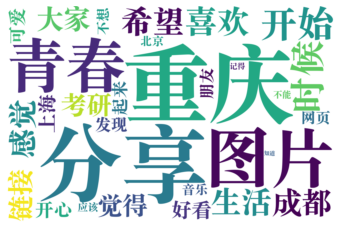

In [423]:
wordcloud = WordCloud(font_path="Songti.ttc",background_color = 'white',collocations = False ,width=3000,height=2000).generate(text_toshow)
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")